## Configuration

In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [2]:
from src.widgets import get_config_widgets, select_features
from src.dataset import get_datasets, normalize_data
from src.feature import create_features, split
from src.prediction import linear_regression, predict_mse, predict_mae, calculate_error_metrics
from src.plot import plot_price_split, feature_importance, plot_predicted

In [3]:
price_interval, prediction_date_picker, eval_size, normalize =  get_config_widgets()

IntRangeSlider(value=(-500, 900), continuous_update=False, description='Energy Price Interval', max=900, min=-…

DatePicker(value=datetime.date(2024, 10, 29), description='Prediction Date', step=1)

FloatSlider(value=0.05, description='Evaluation Set Size', max=0.2, step=0.01)

Checkbox(value=False, description='Normalize')

## Data loading

In [4]:
merged_df, e_price_df = get_datasets()

## Feature Selection

### Best Feature Set (Prophet) - RMSE 7,02
- dayofweek
- dayofyear,
- ma_2_hours
- ma_3_hours
- ma_4_hours
- ma_16_hours
- ma_19_hours
- ma_20_hours
- ma_21_hours
- ma_22_hours
- ma_23_hours,
- Hydro
- Solar
- temperature_2m
- Precipitation (rain/snow)
- direct_radiation
### Best Feature Set (XGBoost)
- hour
- dayofweek
- dayofyear
- ma_3_hours 
- ma_6_hours
- ma_1_days
- ma_7_days 
- Biomass
- Hard Coal
- Hydro
- Lignite
- Natural Gas 
- Nuclear
- Other
- Pumped storage generation
- Solar
- Wind offshore
- Wind onshore
- pumped_storage_generation_ma_3_hours
- pumped_storage_generation_ma_6_hours

In [5]:
get_features, default_features = select_features()

Output()

Button(description='Confirm Selection', style=ButtonStyle())

In [6]:
# RERUN WHEN TICKING the NORMALIZED BOX 

selected_features = get_features()
FEATURES = default_features if not selected_features else selected_features

min_price, max_price = price_interval.value

features_df = create_features(merged_df)
features_interval_df = features_df.copy()[
    (features_df["Price"] >= min_price) &
    (features_df["Price"] <= max_price)
]

normalized_features_df, normalized_e_price_df, normalized_interval_df, e_price_scaler = normalize_data(features_df.copy(), e_price_df.copy(), features_interval_df.copy())

TARGET = merged_df["Price"]
TARGET_INTERVAL = features_interval_df["Price"]
TARGET_NORMALIZED = normalized_features_df["Price"]
TARGET_NORMALIZED_INTERVAL = normalized_interval_df["Price"]

combined_df = pd.concat([features_df[FEATURES], TARGET], axis=1)
combined_interval_df = pd.concat([features_interval_df[FEATURES], TARGET_INTERVAL], axis=1)
combined_normalized_df = pd.concat([normalized_features_df[FEATURES], TARGET_NORMALIZED], axis=1)
combined_normalized_interval_df = pd.concat([normalized_interval_df[FEATURES], TARGET_NORMALIZED_INTERVAL], axis=1)


if normalize.value:
    train, eval, test, SPLIT_DATE_EVAL, SPLIT_DATE_TEST = split(combined_normalized_df,eval_size.value)
    train_XGB, eval_XGB, test_XGB, SPLIT_DATE_EVAL_INTERVAL, SPLIT_DATE_TEST_INTERVAL = split(combined_normalized_interval_df,eval_size.value)
    scalar = e_price_scaler
    
else:
    train, eval, test, SPLIT_DATE_EVAL, SPLIT_DATE_TEST = split(combined_df,eval_size.value)
    train_XGB, eval_XGB, test_XGB, SPLIT_DATE_EVAL_INTERVAL, SPLIT_DATE_TEST_INTERVAL = split(combined_interval_df,eval_size.value)
    scalar = None

TARGET = "Price"

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

X_val = eval[FEATURES]
y_val = eval[TARGET]

X_train_XGB = train_XGB[FEATURES]
y_train_XGB = train_XGB[TARGET]

X_test_XGB = test_XGB[FEATURES]
y_test_XGB = test_XGB[TARGET]

X_val_XGB = eval_XGB[FEATURES]
y_val_XGB = eval_XGB[TARGET]



In [7]:
X_train

,hour,dayofyear,dayofweek,ma_2_hours,ma_3_hours,ma_4_hours,ma_5_hours,ma_6_hours,ma_7_hours,ma_8_hours,...,Nuclear,Other,Pumped storage generation,Solar,Wind offshore,Wind onshore,temperature_2m,precipitation,wind_speed_100m,direct_radiation
2018-10-01 00:00:00,0,274,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.142107,0.041383,0.003477,0.000000,0.029572,0.078357,6.821304,0.000000,35.251360,0.000000
2018-10-01 01:00:00,1,274,0,57.815,NaN,NaN,NaN,NaN,NaN,NaN,...,0.142376,0.041972,0.003478,0.000000,0.037920,0.073151,5.853913,0.000000,35.439972,0.000000
2018-10-01 02:00:00,2,274,0,53.755,55.680000,NaN,NaN,NaN,NaN,NaN,...,0.142441,0.041791,0.003471,0.000000,0.038929,0.071471,5.714783,0.000000,36.011060,0.000000
2018-10-01 03:00:00,3,274,0,49.395,51.630000,53.6050,NaN,NaN,NaN,NaN,...,0.140053,0.041441,0.003452,0.000000,0.039751,0.075943,5.443044,0.000000,35.883137,0.000000
2018-10-01 04:00:00,4,274,0,47.485,48.793333,50.6200,52.402,NaN,NaN,NaN,...,0.138012,0.040888,0.003391,0.000000,0.045451,0.082545,5.245217,0.000000,35.099083,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-28 11:00:00,11,240,0,115.720,118.663333,125.4125,128.432,125.556667,120.955714,116.49125,...,0.000000,0.048103,0.004683,0.266340,0.013799,0.053531,19.693043,0.234783,20.729242,36.112640
2023-08-28 12:00:00,12,240,0,109.965,112.170000,115.2650,121.344,124.538333,122.630000,118.97000,...,0.000000,0.046472,0.001011,0.322664,0.009476,0.043833,19.456087,0.217391,23.494482,40.369900
2023-08-28 13:00:00,13,240,0,102.660,106.726667,109.1900,112.262,117.828333,121.068571,119.83250,...,0.000000,0.046762,0.003181,0.331605,0.008402,0.041455,19.166956,0.817391,23.500988,27.661533
2023-08-28 14:00:00,14,240,0,100.420,101.970000,105.1925,107.470,110.316667,115.365714,118.50875,...,0.000000,0.048368,0.003291,0.296592,0.005169,0.042751,19.014782,0.500000,21.865353,23.637667


In [8]:
X_val

,hour,dayofyear,dayofweek,ma_2_hours,ma_3_hours,ma_4_hours,ma_5_hours,ma_6_hours,ma_7_hours,ma_8_hours,...,Nuclear,Other,Pumped storage generation,Solar,Wind offshore,Wind onshore,temperature_2m,precipitation,wind_speed_100m,direct_radiation
2023-08-28 16:00:00,16,240,0,117.025,111.546667,108.7225,107.992,109.136667,110.200000,111.99375,...,0.0,0.050545,0.004130,0.203235,0.011085,0.047721,18.149565,0.347826,19.727910,10.380979
2023-08-28 17:00:00,17,240,0,133.310,128.066667,121.1975,117.008,115.018333,114.995714,115.19375,...,0.0,0.052267,0.016150,0.135833,0.010653,0.046230,17.606087,0.343478,20.386944,2.443107
2023-08-28 18:00:00,18,240,0,156.500,143.156667,136.7625,129.528,124.648333,121.851429,120.97750,...,0.0,0.055852,0.035705,0.071101,0.007067,0.049446,16.793043,0.052174,21.475570,0.448001
2023-08-28 19:00:00,19,240,0,168.905,162.653333,151.1075,144.402,137.100000,131.835714,128.49000,...,0.0,0.059089,0.040059,0.018856,0.006995,0.049639,15.853913,0.039130,22.114943,0.000000
2023-08-28 20:00:00,20,240,0,170.845,168.180000,163.6725,154.232,148.123333,141.332857,136.19750,...,0.0,0.058528,0.047704,0.000351,0.009444,0.045929,15.114783,0.034783,22.425896,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-01 13:00:00,13,335,4,186.140,195.266667,200.2925,204.760,204.543333,197.052857,187.42500,...,0.0,0.049511,0.018378,0.017457,0.019188,0.025748,2.288696,0.052174,19.089321,66.344320
2023-12-01 14:00:00,14,335,4,174.755,182.200000,190.0300,195.098,199.686667,200.225714,194.21125,...,0.0,0.048216,0.013472,0.011005,0.018373,0.027776,2.099565,0.065217,19.081950,30.753704
2023-12-01 15:00:00,15,335,4,179.360,177.970000,182.7500,188.904,193.315000,197.502857,198.24750,...,0.0,0.046320,0.014316,0.003196,0.022705,0.033106,0.845217,0.065217,20.132620,5.572041
2023-12-01 16:00:00,16,335,4,192.225,186.256667,183.4900,186.210,190.761667,194.277143,197.82125,...,0.0,0.046232,0.018714,0.000062,0.028235,0.038987,0.071304,0.086957,22.534850,0.000000


In [9]:
X_test

,hour,dayofyear,dayofweek,ma_2_hours,ma_3_hours,ma_4_hours,ma_5_hours,ma_6_hours,ma_7_hours,ma_8_hours,...,Nuclear,Other,Pumped storage generation,Solar,Wind offshore,Wind onshore,temperature_2m,precipitation,wind_speed_100m,direct_radiation
2023-12-01 18:00:00,18,335,4,214.925,209.966667,203.5750,197.724,193.968333,194.414286,196.80250,...,0.0,0.044160,0.019283,0.0,0.035383,0.046434,0.019130,0.104348,21.796940,0.0
2023-12-01 19:00:00,19,335,4,183.860,199.470000,199.6150,196.572,192.863333,190.338571,191.18250,...,0.0,0.044673,0.009531,0.0,0.037026,0.043323,-0.243913,0.108696,20.260021,0.0
2023-12-01 20:00:00,20,335,4,155.465,170.030000,185.1950,188.166,187.538333,185.650000,184.34250,...,0.0,0.044879,0.004766,0.0,0.034766,0.043247,-0.500435,0.086957,18.537052,0.0
2023-12-01 21:00:00,21,335,4,133.750,145.353333,158.8050,173.182,177.660000,178.622857,178.08500,...,0.0,0.045807,0.001909,0.0,0.032994,0.043666,-0.809130,0.073913,16.824299,0.0
2023-12-01 22:00:00,22,335,4,121.765,128.633333,138.6150,150.724,164.051667,169.194286,171.09500,...,0.0,0.046377,0.004002,0.0,0.030117,0.043855,-0.954783,0.069565,15.699009,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-29 19:00:00,19,303,1,230.630,249.020000,239.9450,226.408,211.330000,197.958571,186.39500,...,0.0,0.040608,0.030011,0.0,0.026560,0.090070,12.706086,0.030435,33.168320,0.0
2024-10-29 20:00:00,20,303,1,172.210,200.620000,221.9150,220.076,212.106667,201.225714,190.78875,...,0.0,0.044794,0.014459,0.0,0.027928,0.097331,12.095218,0.000000,31.254880,0.0
2024-10-29 21:00:00,21,303,1,132.325,156.156667,181.4775,202.342,204.071667,199.527143,191.57875,...,0.0,0.046835,0.002805,0.0,0.030024,0.096333,11.658260,0.008696,28.722576,0.0
2024-10-29 22:00:00,22,303,1,121.065,127.576667,146.6375,168.798,188.298333,191.787143,189.34625,...,0.0,0.046154,0.001140,0.0,0.035149,0.097447,11.536522,0.004348,26.723137,0.0


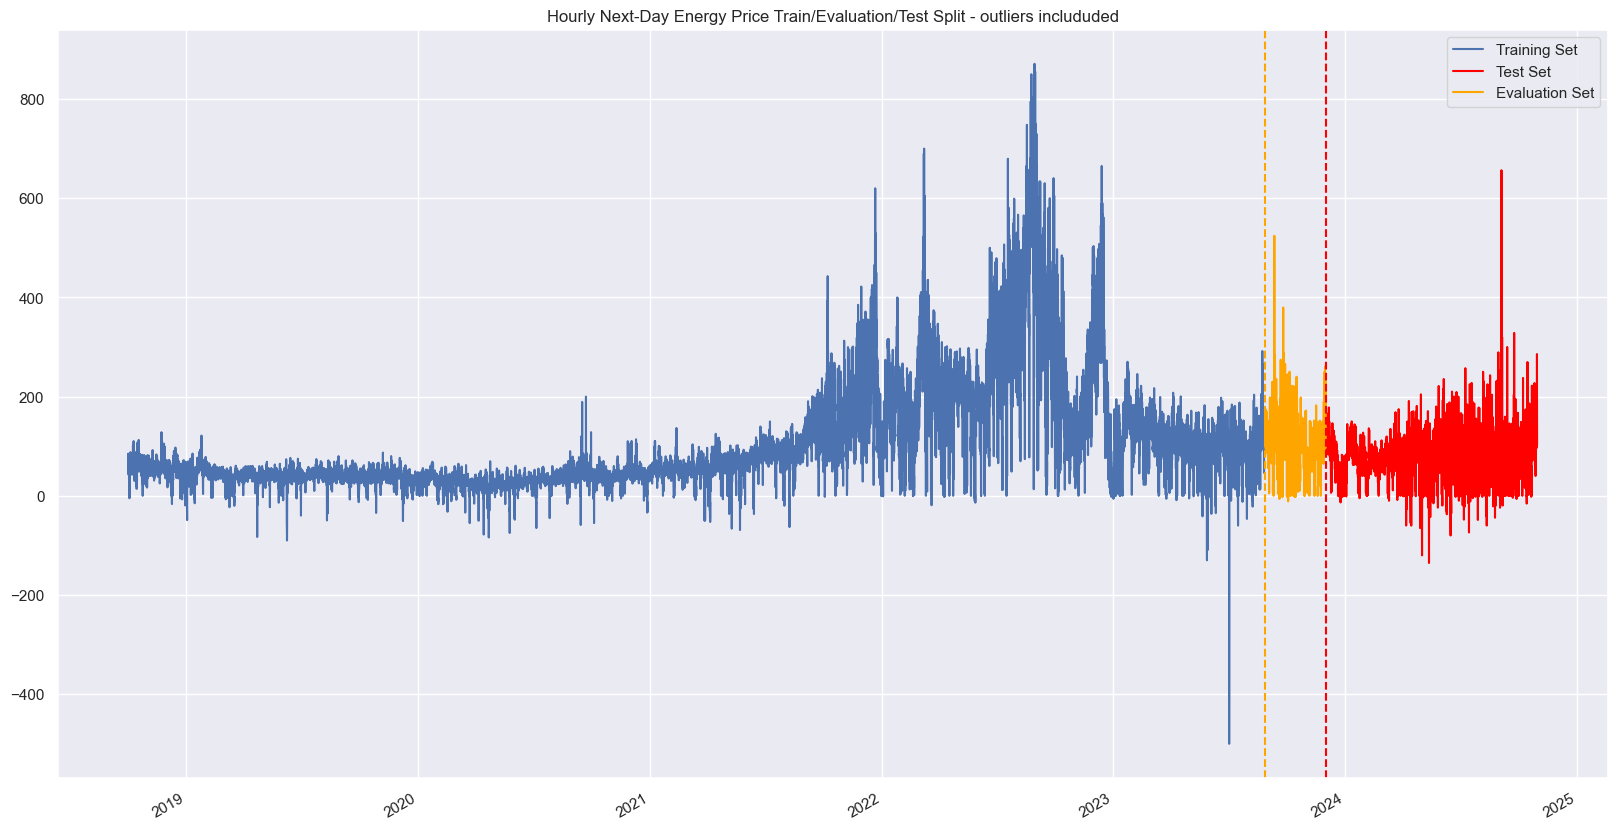

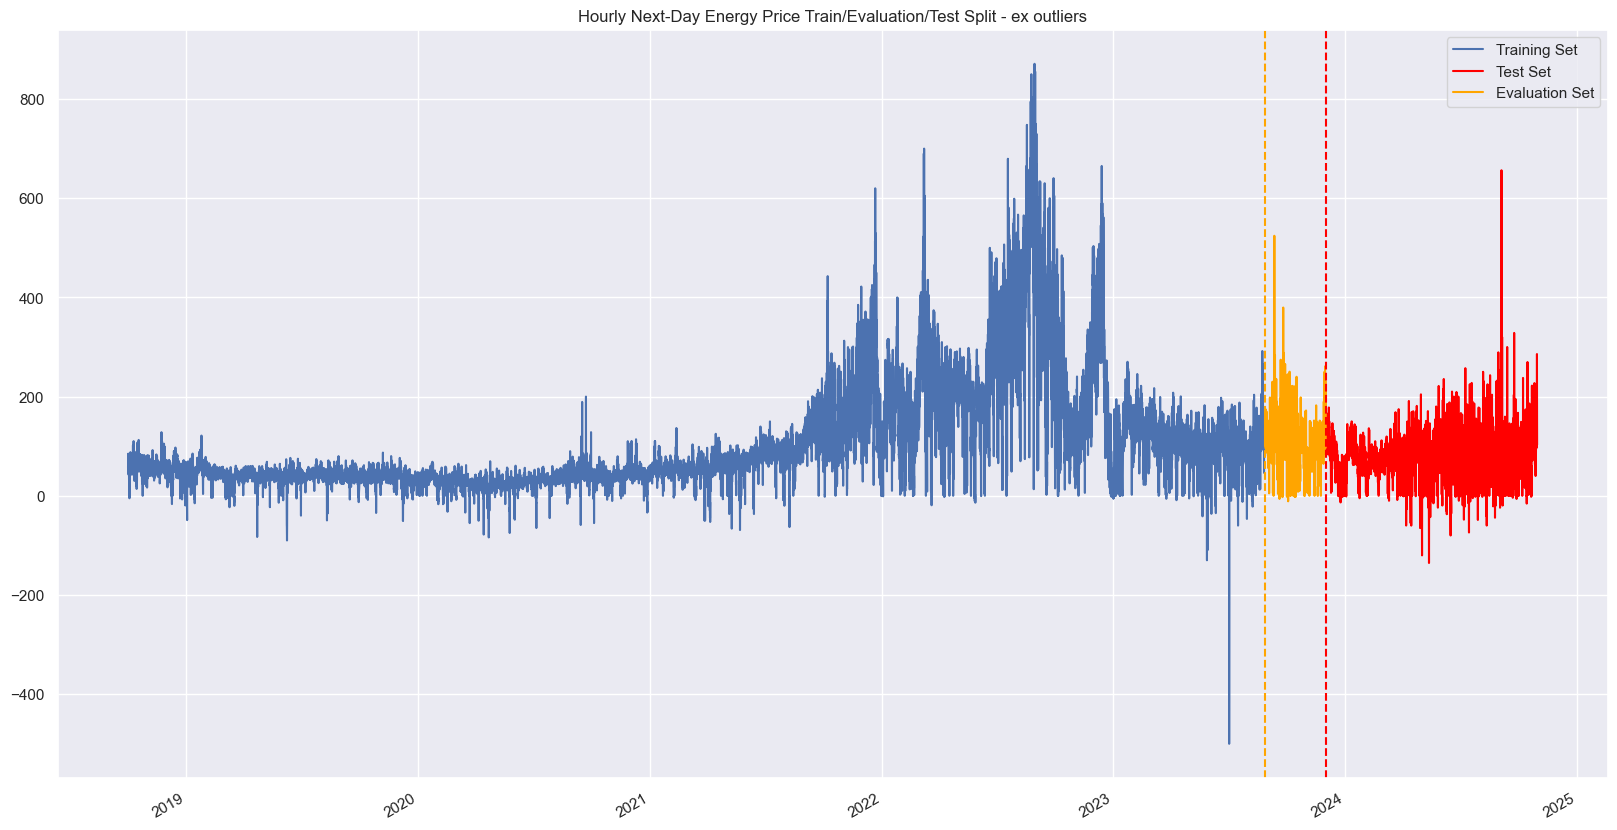

In [10]:
plot_price_split(train, eval, test, SPLIT_DATE_EVAL, SPLIT_DATE_TEST, "outliers includuded")
plot_price_split(train_XGB, eval_XGB, test_XGB, SPLIT_DATE_EVAL_INTERVAL, SPLIT_DATE_TEST_INTERVAL, "ex outliers")

## Prediction

### Linear Regression

In [11]:
lr_predictions  = linear_regression(X_train, y_train, X_test, y_test, scalar)
lr_predictions_interval = linear_regression(X_train_XGB, y_train_XGB, X_test_XGB, y_test_XGB, scalar)

### XGBoost

In [12]:
best_params = {
    "base_score": 0.380924762889507,
    "early_stopping_rounds": 215,
    "max_depth": 80,
    "learning_rate": 0.06,
    "n_estimators": 150,
    "gamma": 0.9,
    "min_child_weight": 6,
    "subsample": 0.5719023844219375,
    "colsample_bytree": 0.8815691043681952,
}
xgb_y_predicted_mse, xgb_mse = predict_mse(best_params, X_train_XGB, y_train_XGB, X_val_XGB, y_val_XGB, X_test_XGB)
xgb_y_predicted_mae, xgb_mae = predict_mae(best_params, X_train_XGB, y_train_XGB, X_val_XGB, y_val_XGB, X_test_XGB)

[0]	validation_0-rmse:98.91330
[25]	validation_0-rmse:22.34169
[50]	validation_0-rmse:8.66586
[75]	validation_0-rmse:7.16964
[100]	validation_0-rmse:6.98104
[125]	validation_0-rmse:6.95885
[149]	validation_0-rmse:6.91091
[0]	validation_0-mae:88.55362
[25]	validation_0-mae:19.09768
[50]	validation_0-mae:5.58097
[75]	validation_0-mae:3.64236
[100]	validation_0-mae:3.48433
[125]	validation_0-mae:3.47588
[149]	validation_0-mae:3.46412


### Prophet

In [13]:
# Initialize Prophet model
model = Prophet(
    changepoint_prior_scale = 0.5,
    seasonality_prior_scale = 1.0,
    holidays_prior_scale = 1.0,
    seasonality_mode= 'multiplicative'
)

#Add fourier order for weekly and monthly seasonality
model.add_seasonality(name='weekly', period=7, fourier_order=100)
model.add_seasonality(name='monthly', period=30.5, fourier_order=100)
model.add_seasonality(name='yearly', period=365, fourier_order=100)

# Add time-based regressors

for feature in FEATURES:
     model.add_regressor(feature)
     
train_data = train.rename(columns={"Price": "y"}).reset_index().rename(columns={"index": "ds"}).dropna()

model.fit(train_data)


16:39:10 - cmdstanpy - INFO - Chain [1] start processing
16:41:16 - cmdstanpy - INFO - Chain [1] done processing


In [14]:
test_data = test.reset_index().rename(columns={"index": "ds"}).dropna()
test_data.drop(columns=["Price"])
prophet_predictions = model.predict(test_data)["yhat"]

## Results

### Errors

In [15]:
calculate_error_metrics(y_test, [lr_predictions, prophet_predictions, xgb_y_predicted_mse])

            Model      MAE       MSE     RMSE         MAPE
Linear Regression 3.312342 34.996217 5.915760 8.788715e+15
          Prophet 3.332289 33.690189 5.804325 9.441853e+15
          XGBoost 3.324459 36.947839 6.078473 2.652766e+15


### Plots

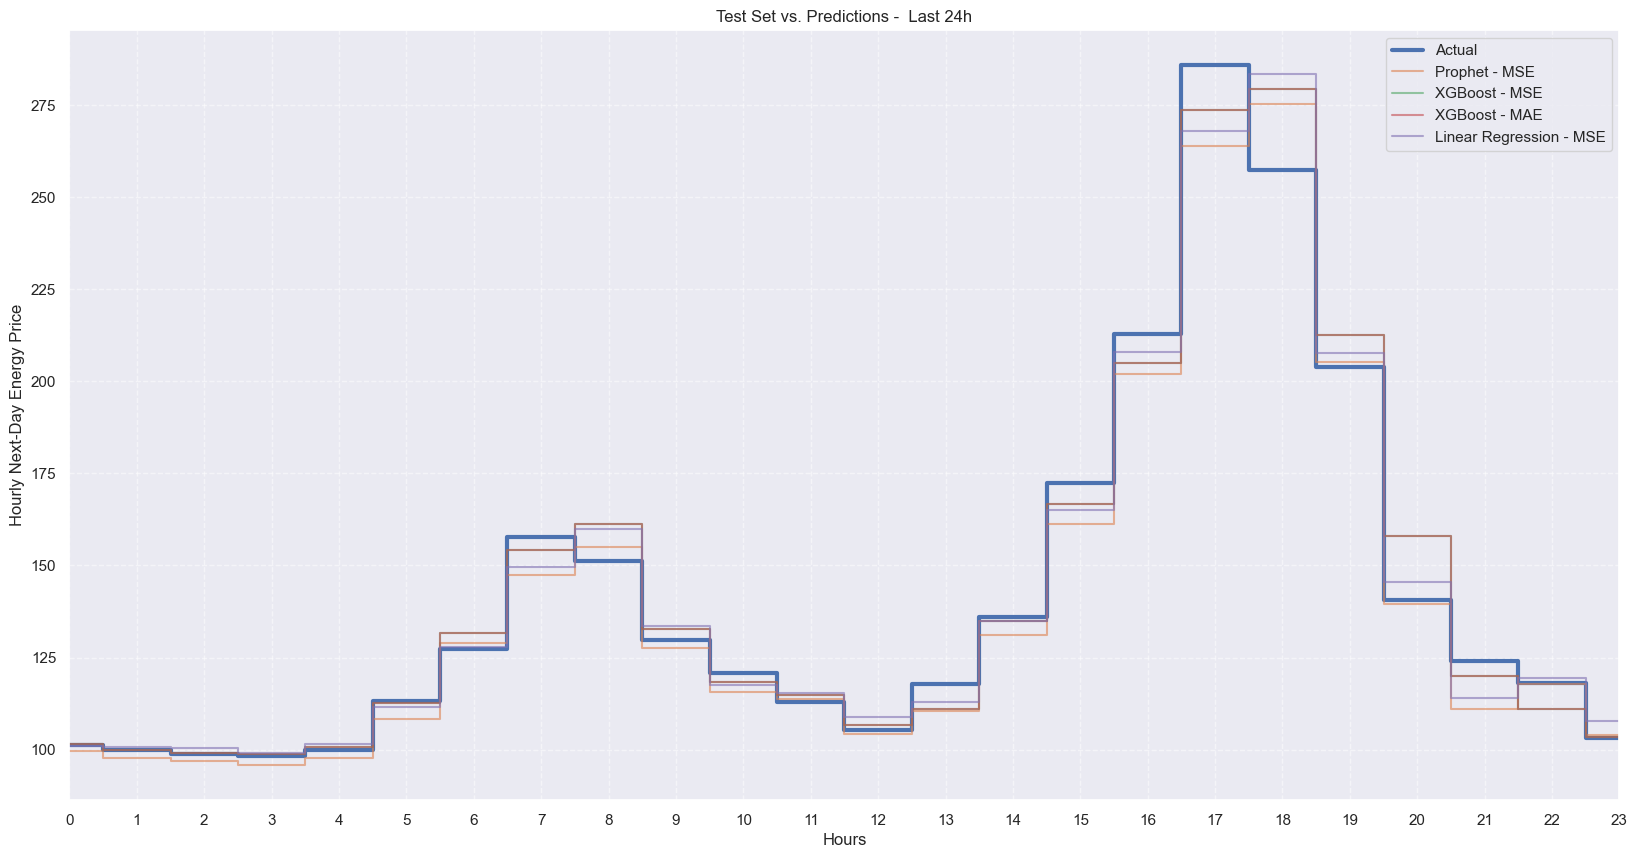

In [16]:
predictions = [(prophet_predictions, "Prophet", "MSE"), (xgb_y_predicted_mse, "XGBoost","MSE"), (xgb_y_predicted_mae, "XGBoost","MAE"), (lr_predictions, "Linear Regression","MSE")]

plot_predicted(y_test, predictions, prediction_date_picker.value)

### XGBoost - Feature Importance

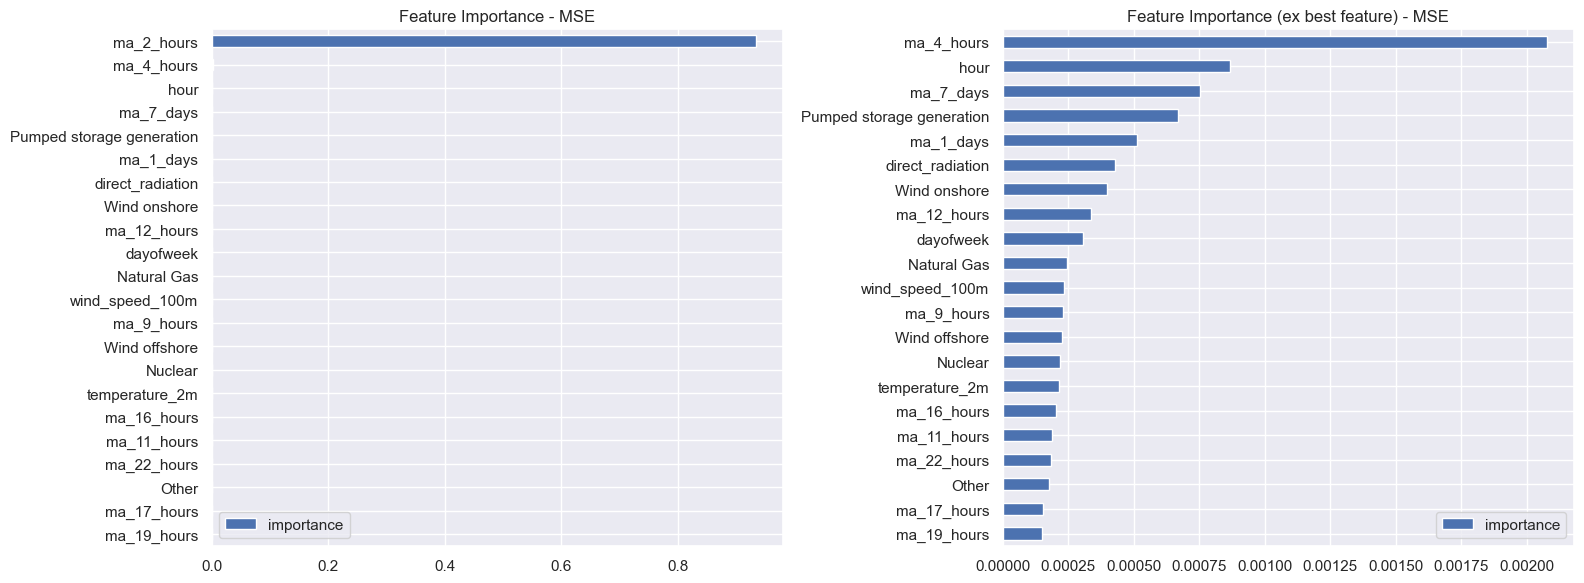

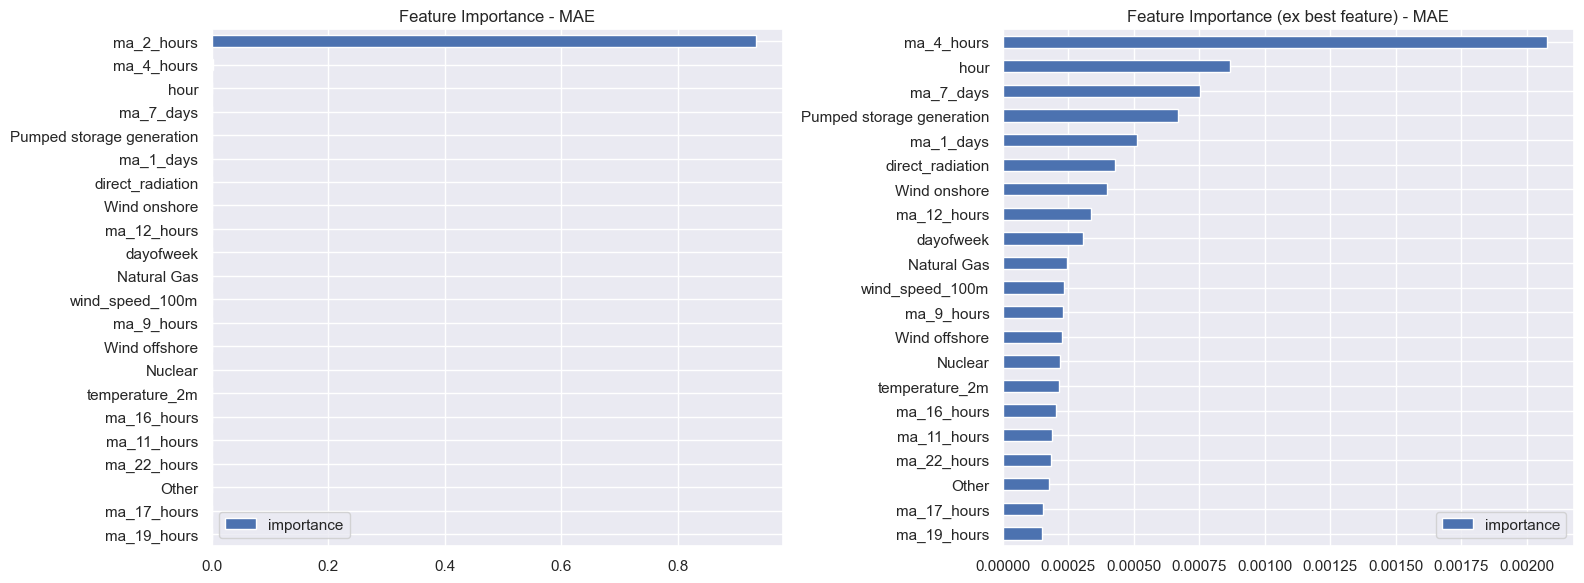

In [17]:
feature_importance(xgb_mse, "MSE")
feature_importance(xgb_mae, "MAE")

In [ ]:
from prophet.diagnostics import cross_validation, performance_metrics

df_cv = cross_validation(model, horizon='30 days', period='7 days', initial='365 days')
df_performance = performance_metrics(df_cv)

print(df_performance[['horizon', 'rmse', 'mse', 'mae', 'mape']])

  0%|          | 0/199 [00:00<?, ?it/s]

16:41:30 - cmdstanpy - INFO - Chain [1] start processing
16:41:50 - cmdstanpy - INFO - Chain [1] done processing
16:41:56 - cmdstanpy - INFO - Chain [1] start processing
16:42:19 - cmdstanpy - INFO - Chain [1] done processing
16:42:26 - cmdstanpy - INFO - Chain [1] start processing
16:42:46 - cmdstanpy - INFO - Chain [1] done processing
16:42:53 - cmdstanpy - INFO - Chain [1] start processing
16:43:12 - cmdstanpy - INFO - Chain [1] done processing
16:43:18 - cmdstanpy - INFO - Chain [1] start processing
16:43:35 - cmdstanpy - INFO - Chain [1] done processing
16:43:42 - cmdstanpy - INFO - Chain [1] start processing
16:44:00 - cmdstanpy - INFO - Chain [1] done processing
16:44:07 - cmdstanpy - INFO - Chain [1] start processing
16:44:24 - cmdstanpy - INFO - Chain [1] done processing
16:44:31 - cmdstanpy - INFO - Chain [1] start processing
16:44:48 - cmdstanpy - INFO - Chain [1] done processing
16:44:56 - cmdstanpy - INFO - Chain [1] start processing
16:45:17 - cmdstanpy - INFO - Chain [1]